In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
tf.keras.backend.clear_session()

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
subject = 'Roraima - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_RR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Roraima - IDH,Roraima - IDH Longevidade,Roraima - Consumo de Cimento (t),Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.734916,0.737579,6.920,12652.753600,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,0.721714,137154.814617,6.128460e+06,332580.202821,12.101540,5.339136e+06,0.766811,8.263084,0.294583,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.734957,0.737903,7.476,12757.336292,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,0.721974,138007.572103,6.136622e+06,332914.755543,12.103485,5.342057e+06,0.766348,8.257123,0.296505,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.734998,0.738226,8.659,12860.789996,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,0.722235,138860.329589,6.144784e+06,333249.308265,12.105429,5.344978e+06,0.765885,8.251161,0.298178,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.735038,0.738550,7.259,12962.516425,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,0.722495,139713.087075,6.152947e+06,333583.860987,12.107373,5.347899e+06,0.765422,8.245199,0.299598,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.735079,0.738873,6.786,13063.753666,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,0.722756,140565.844561,6.161109e+06,333918.413709,12.109318,5.350821e+06,0.764958,8.239238,0.300965,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,38506.140515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,38458.886125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,38396.986094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,38312.397156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


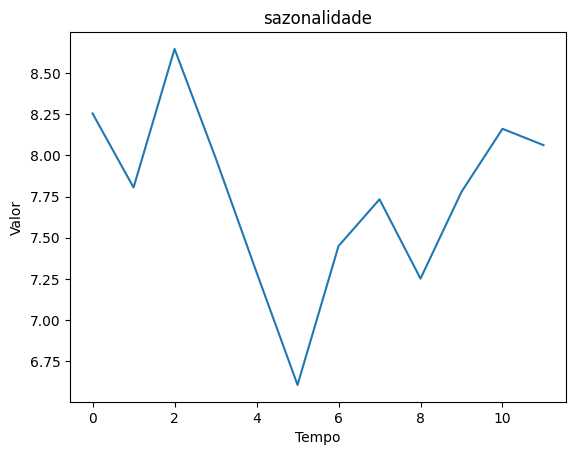

,sazonalidade
sazonalidade,
0,8.254748
1,7.805187
2,8.646925
3,7.985925
4,7.290338
5,6.606015
6,7.449672
7,7.733340
8,7.251604


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Roraima - IDH,Roraima - IDH Longevidade,Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Roraima - Consumo de Cimento (t)
0,2003-1,0.734916,0.737579,12652.753600,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,0.721714,137154.814617,6.128460e+06,332580.202821,12.101540,5.339136e+06,0.766811,8.263084,0.294583,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.254748,6.920
1,2003-2,0.734957,0.737903,12757.336292,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,0.721974,138007.572103,6.136622e+06,332914.755543,12.103485,5.342057e+06,0.766348,8.257123,0.296505,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,7.805187,7.476
2,2003-3,0.734998,0.738226,12860.789996,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,0.722235,138860.329589,6.144784e+06,333249.308265,12.105429,5.344978e+06,0.765885,8.251161,0.298178,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.646925,8.659
3,2003-4,0.735038,0.738550,12962.516425,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,0.722495,139713.087075,6.152947e+06,333583.860987,12.107373,5.347899e+06,0.765422,8.245199,0.299598,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,7.985925,7.259
4,2003-5,0.735079,0.738873,13063.753666,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,0.722756,140565.844561,6.161109e+06,333918.413709,12.109318,5.350821e+06,0.764958,8.239238,0.300965,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,7.290338,6.786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,38506.140515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.290338,NaN
245,2023-6,NaN,NaN,38458.886125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.606015,NaN
246,2023-7,NaN,NaN,38396.986094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.449672,NaN
247,2023-8,NaN,NaN,38312.397156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.733340,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      2.928
1      2.118
2      2.876
3      3.091
4      2.684
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Roraima - Consumo de Cimento (t), Length: 249, dtype: float64

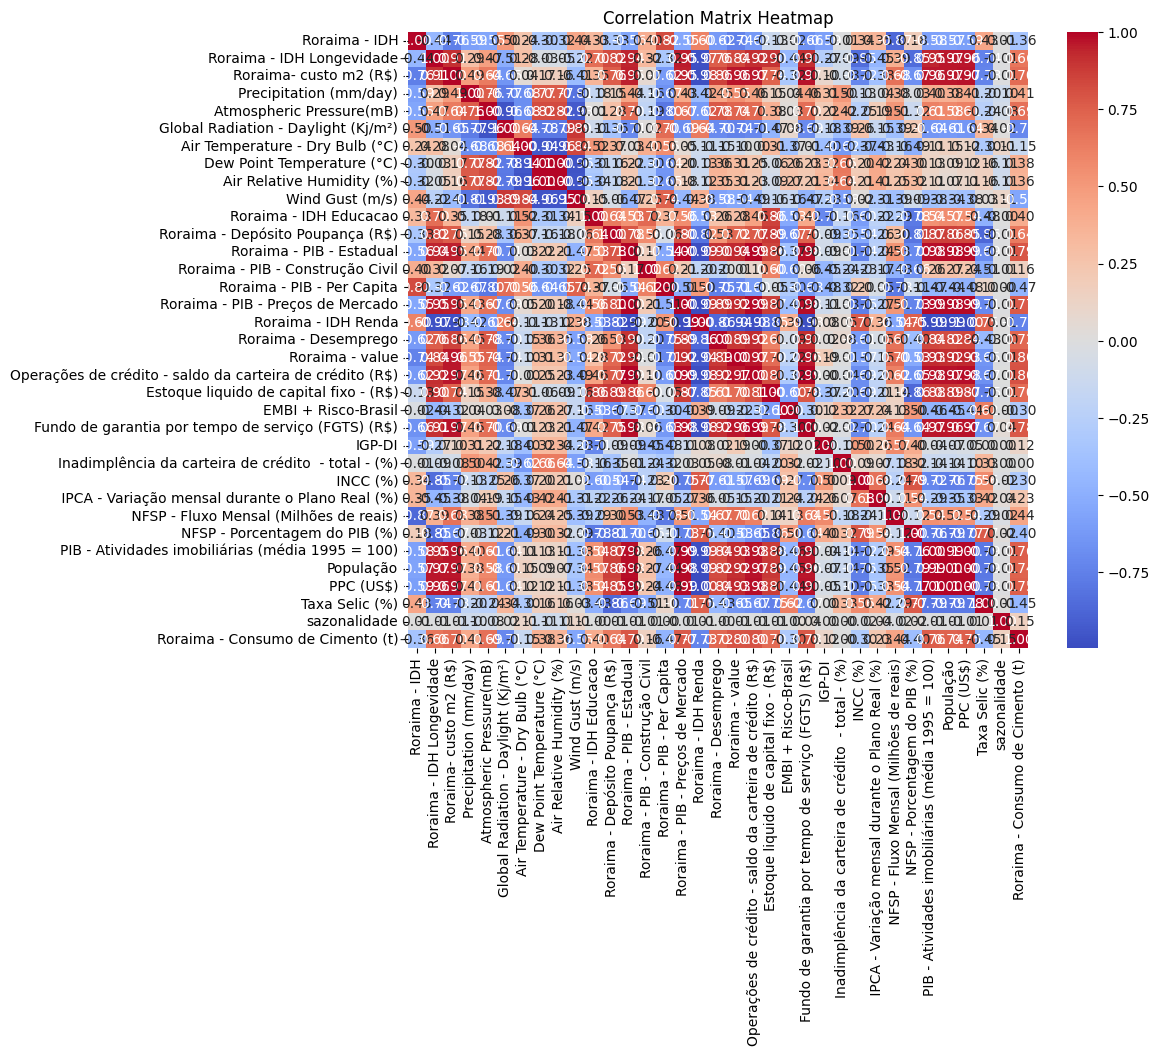

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Roraima - IDH,5.859900e+08
1,Roraima - IDH Longevidade,2.258616e+08
2,Roraima- custo m2 (R$),1.927989e+06
3,Precipitation (mm/day),4.685217e+01
4,Atmospheric Pressure(mB),5.405260e+07
5,Global Radiation - Daylight (Kj/m²),5.284073e+03
6,Air Temperature - Dry Bulb (°C),1.244527e+06
7,Dew Point Temperature (°C),8.274014e+05
8,Air Relative Humidity (%),6.669328e+05
9,Wind Gust (m/s),9.128561e+03


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 8


,Roraima- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,12652.753600,2.058778,1671.347636,25.569094,22.736364,82.325261,1.614960,137154.814617,6.128460e+06,332580.202821,0.766811,8.263084,0.294583,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,8.254748
1,12757.336292,2.058778,1671.347636,25.575369,22.731191,82.325261,1.615759,138007.572103,6.136622e+06,332914.755543,0.766348,8.257123,0.296505,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,7.805187
2,12860.789996,2.058778,1671.347636,25.579030,22.728173,82.325261,1.616226,138860.329589,6.144784e+06,333249.308265,0.765885,8.251161,0.298178,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,8.646925
3,12962.516425,2.058778,1671.347636,25.579422,22.727849,82.325261,1.616276,139713.087075,6.152947e+06,333583.860987,0.765422,8.245199,0.299598,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,7.985925
4,13063.753666,2.047445,1673.953674,25.600512,22.700959,82.163288,1.626211,140565.844561,6.161109e+06,333918.413709,0.764958,8.239238,0.300965,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,7.290338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,29081.273556,3.315226,1464.911620,27.205680,21.502529,73.126938,1.529399,556048.927820,7.466066e+06,340525.849294,0.700273,10.120145,0.474150,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,7.733340
200,29297.176393,3.110927,1501.688636,27.408918,21.525487,72.235759,1.604864,565474.227144,7.458437e+06,340575.996406,0.700110,10.075841,0.478166,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,7.251604
201,29527.699167,2.870517,1519.193331,27.520810,21.212479,70.455472,1.726242,574899.526468,7.450808e+06,340626.143518,0.699946,10.031538,0.482245,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,7.778761
202,29778.324778,2.589865,1531.726608,27.698342,20.738523,68.013168,1.884139,584324.825793,7.443179e+06,340676.290630,0.699783,9.987234,0.486386,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,8.161704


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.666756,-0.170624,-1.951716,1.516022,1.543876,-0.975594,-1.992407,-1.706383,-2.557337,1.897831,-0.755014,-0.881846,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,0.666756,-0.170624,-1.946775,1.513152,1.543876,-0.974651,-1.985464,-1.689675,-2.471707,1.875373,-0.760215,-0.852169,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,0.666756,-0.170624,-1.943892,1.511477,1.543876,-0.974100,-1.978522,-1.672967,-2.386076,1.852915,-0.765416,-0.826351,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,0.666756,-0.170624,-1.943583,1.511298,1.543876,-0.974042,-1.971579,-1.656258,-2.300446,1.830457,-0.770617,-0.804421,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,0.655258,-0.160750,-1.926975,1.496380,1.531023,-0.962321,-1.964637,-1.639550,-2.214815,1.808000,-0.775819,-0.783322,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.941488,-0.952768,-0.662938,0.831505,0.813960,-1.076528,1.417931,1.031735,-0.523610,-1.328255,0.865191,1.890064,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,1.734216,-0.813428,-0.502893,0.844241,0.743242,-0.987503,1.494665,1.016119,-0.510775,-1.336182,0.826538,1.952054,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,1.490308,-0.747106,-0.414781,0.670588,0.601970,-0.844316,1.571399,1.000503,-0.497940,-1.344109,0.787885,2.015011,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,1.205572,-0.699620,-0.274978,0.407643,0.408166,-0.658048,1.648133,0.984887,-0.485104,-1.352037,0.749232,2.078947,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.666756,-0.170624,-1.951716,1.516022,1.543876,-0.975594,-1.992407,-1.706383,-2.557337,1.897831,-0.755014,-0.881846,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,0.666756,-0.170624,-1.946775,1.513152,1.543876,-0.974651,-1.985464,-1.689675,-2.471707,1.875373,-0.760215,-0.852169,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,0.666756,-0.170624,-1.943892,1.511477,1.543876,-0.974100,-1.978522,-1.672967,-2.386076,1.852915,-0.765416,-0.826351,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,0.666756,-0.170624,-1.943583,1.511298,1.543876,-0.974042,-1.971579,-1.656258,-2.300446,1.830457,-0.770617,-0.804421,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,0.655258,-0.160750,-1.926975,1.496380,1.531023,-0.962321,-1.964637,-1.639550,-2.214815,1.808000,-0.775819,-0.783322,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2.271705,-0.641698,-0.353008,0.642306,0.576875,-0.941668,0.683780,1.180219,-0.591091,-1.280200,1.212805,1.327000,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,2.045903,-0.574376,-0.227717,0.473104,0.428382,-0.750386,0.723182,1.172385,-0.595565,-1.278712,1.197396,1.356606,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,1.234985,-0.535305,-0.024018,0.231748,0.213426,-0.529525,0.762585,1.164551,-0.600038,-1.277225,1.181988,1.389202,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,0.622066,-0.550319,-0.001842,-0.010841,0.068382,-0.258552,0.801987,1.156717,-0.604511,-1.275738,1.166580,1.424665,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       2.928
1       2.118
2       2.876
3       3.091
4       2.684
        ...  
187    13.513
188    15.571
189    15.077
190    14.792
191    13.671
Name: Roraima - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 24)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,-0.581137,-0.530627,0.718772,-0.259639,-0.299104,-0.122751,0.110005,1.129068,-0.527145,-1.170119,1.427014,0.966347,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,-0.042944,-0.785676,0.453382,0.071869,-0.023255,-0.299110,0.116114,1.137026,-0.537953,-1.175800,1.410252,0.971659,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,0.270562,-0.883139,0.127494,0.283923,0.227350,-0.520156,0.122224,1.144984,-0.548760,-1.181480,1.393489,0.976542,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,0.935058,-1.062224,-0.416626,0.651789,0.627028,-0.792882,0.128334,1.152942,-0.559567,-1.187161,1.376726,0.980984,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,0.960600,-1.065025,-0.689290,0.806396,0.814751,-0.952103,0.134443,1.160900,-0.570374,-1.192842,1.359964,0.984674,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,1.135498,-0.840045,-0.725792,0.818213,0.832167,-1.028346,0.140553,1.168858,-0.581182,-1.198522,1.343201,0.989169,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,1.566072,-0.576070,-0.244856,0.684890,0.596954,-1.004671,0.146663,1.176816,-0.591989,-1.204203,1.326438,0.993888,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,1.273869,-0.416846,0.397346,0.551689,0.291672,-0.921117,0.152772,1.184774,-0.602796,-1.209883,1.309675,1.000092,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,1.760688,-0.334348,0.682767,0.422262,0.110655,-0.801735,0.158882,1.192732,-0.613604,-1.215564,1.292913,1.009760,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,1.565811,-0.386804,0.848128,0.259172,-0.045542,-0.670894,0.164992,1.200690,-0.624411,-1.221244,1.276150,1.019192,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(18, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2183642744, 3749316579, 3005928027, 81583189, 3498971732, 4125269619, 3522434865, 2450741843, 2069148143, 430324243]


Step: 0 ___________________________________________
val_loss: 5.0904364585876465
winner_seed: 2183642744


Step: 1 ___________________________________________
val_loss: 5.435460567474365


Step: 2 ___________________________________________
val_loss: 5.357893943786621


Step: 3 ___________________________________________
val_loss: 4.828840732574463
winner_seed: 81583189


Step: 4 ___________________________________________
val_loss: 5.316143989562988


Step: 5 ___________________________________________
val_loss: 5.689213275909424


Step: 6 ___________________________________________
val_loss: 6.1584086418151855


Step: 7 ___________________________________________
val_loss: 5.570645332336426


Step: 8 ___________________________________________
val_loss: 6.5431365966796875


Step: 9 ___________________________________________
val_loss: 6.2262492179870605


final_seed

In [ ]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 96ms/step - loss: 69.6788 - val_loss: 118.9169
Epoch 2/10000
5/5 [==============================] - 0s 9ms/step - loss: 50.9452 - val_loss: 90.4885
Epoch 3/10000
5/5 [==============================] - 0s 9ms/step - loss: 32.9948 - val_loss: 64.4706
Epoch 4/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.7363 - val_loss: 44.5485
Epoch 5/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.9247 - val_loss: 29.7340
Epoch 6/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.6336 - val_loss: 23.0141
Epoch 7/10000
5/5 [==============================] - 0s 9ms/step - loss: 5.1281 - val_loss: 17.9784
Epoch 8/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.0987 - val_loss: 15.1972
Epoch 9/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.6694 - val_loss: 13.3752
Epoch 10/10000
5/5 [==============================] - 0s 9ms/step - loss: 3.4316 - val_loss: 

5/5 [==============================] - 0s 9ms/step - loss: 2.3884 - val_loss: 8.5192
Epoch 83/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.3471 - val_loss: 7.6992
Epoch 84/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.3850 - val_loss: 8.1386
Epoch 85/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.4386 - val_loss: 8.3516
Epoch 86/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3027 - val_loss: 8.2907
Epoch 87/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3103 - val_loss: 8.6379
Epoch 88/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3138 - val_loss: 7.9630
Epoch 89/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.2451 - val_loss: 8.8331
Epoch 90/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.4374 - val_loss: 8.0795
Epoch 91/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.3601 - val_loss: 8.2251
Epoch 92/100

5/5 [==============================] - 0s 10ms/step - loss: 2.2686 - val_loss: 7.4251
Epoch 164/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2783 - val_loss: 7.5369
Epoch 165/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2321 - val_loss: 7.1540
Epoch 166/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2859 - val_loss: 7.3796
Epoch 167/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2101 - val_loss: 7.2625
Epoch 168/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.2311 - val_loss: 7.3689
Epoch 169/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1845 - val_loss: 7.3438
Epoch 170/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.2197 - val_loss: 7.5382
Epoch 171/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1935 - val_loss: 7.6327
Epoch 172/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1944 - val_loss: 7.6269
Epoch

5/5 [==============================] - 0s 9ms/step - loss: 2.0879 - val_loss: 7.8132
Epoch 245/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1101 - val_loss: 7.3709
Epoch 246/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.0976 - val_loss: 7.5001
Epoch 247/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1224 - val_loss: 7.4551
Epoch 248/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1079 - val_loss: 7.3185
Epoch 249/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1258 - val_loss: 7.4188
Epoch 250/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0961 - val_loss: 7.2933
Epoch 251/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.1631 - val_loss: 7.2313
Epoch 252/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0585 - val_loss: 7.2498
Epoch 253/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.1173 - val_loss: 7.2534
Epoch

5/5 [==============================] - 0s 10ms/step - loss: 2.0676 - val_loss: 7.2630
Epoch 326/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.9941 - val_loss: 6.9381
Epoch 327/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0282 - val_loss: 7.2424
Epoch 328/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0488 - val_loss: 7.1036
Epoch 329/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0179 - val_loss: 7.1057
Epoch 330/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0397 - val_loss: 7.0864
Epoch 331/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0905 - val_loss: 7.1212
Epoch 332/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0031 - val_loss: 7.1596
Epoch 333/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.9967 - val_loss: 7.0479
Epoch 334/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.0096 - val_loss: 7.0794
Epoch

5/5 [==============================] - 0s 9ms/step - loss: 2.0048 - val_loss: 6.7538
Epoch 407/10000
5/5 [==============================] - 0s 7ms/step - loss: 1.9244 - val_loss: 6.9922
Epoch 408/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.9030 - val_loss: 6.9854
Epoch 409/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.8923 - val_loss: 7.0161
Epoch 410/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.9531 - val_loss: 6.9839
Epoch 411/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.9372 - val_loss: 6.9409
Epoch 412/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.9242 - val_loss: 6.7824
Epoch 413/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.9672 - val_loss: 6.8273
Epoch 414/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.8937 - val_loss: 7.1354
Epoch 415/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.0014 - val_loss: 7.0553
Epoch 

5/5 [==============================] - 0s 9ms/step - loss: 1.8646 - val_loss: 6.9362
Epoch 488/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.8427 - val_loss: 6.9729
Epoch 489/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.8460 - val_loss: 6.8264
Epoch 490/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.8169 - val_loss: 7.2420
Epoch 491/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.8358 - val_loss: 7.2797
Epoch 492/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.8427 - val_loss: 7.0326
Epoch 493/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7960 - val_loss: 6.8605
Epoch 494/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.8068 - val_loss: 6.8877
Epoch 495/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7843 - val_loss: 6.8724
Epoch 496/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7698 - val_loss: 6.9068
Epoc

5/5 [==============================] - 0s 10ms/step - loss: 1.7061 - val_loss: 6.7887
Epoch 569/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.6442 - val_loss: 6.8607
Epoch 570/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.7192 - val_loss: 6.6863
Epoch 571/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.7567 - val_loss: 6.8670
Epoch 572/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.6463 - val_loss: 6.7645
Epoch 573/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.7143 - val_loss: 6.7145
Epoch 574/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6823 - val_loss: 6.5028
Epoch 575/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6994 - val_loss: 6.7275
Epoch 576/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7380 - val_loss: 6.9055
Epoch 577/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7130 - val_loss: 6.7612

Epoch 649/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6106 - val_loss: 6.7802
Epoch 650/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6873 - val_loss: 6.7653
Epoch 651/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6789 - val_loss: 6.9125
Epoch 652/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5843 - val_loss: 6.6789
Epoch 653/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6183 - val_loss: 6.8089
Epoch 654/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.5614 - val_loss: 6.4860
Epoch 655/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6248 - val_loss: 6.8360
Epoch 656/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6990 - val_loss: 6.9089
Epoch 657/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6081 - val_loss: 6.7004
Epoch 658/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5908 

Epoch 730/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5290 - val_loss: 6.9225
Epoch 731/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6491 - val_loss: 6.7449
Epoch 732/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5773 - val_loss: 6.5476
Epoch 733/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5949 - val_loss: 6.4856
Epoch 734/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.5238 - val_loss: 7.2568
Epoch 735/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6589 - val_loss: 6.7332
Epoch 736/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5217 - val_loss: 6.6828
Epoch 737/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5535 - val_loss: 6.7958
Epoch 738/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.6056 - val_loss: 6.7434
Epoch 739/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5324 - v

Epoch 811/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5504 - val_loss: 7.0569
Epoch 812/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5688 - val_loss: 6.5961
Epoch 813/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6589 - val_loss: 6.7175
Epoch 814/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5255 - val_loss: 6.6872
Epoch 815/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5236 - val_loss: 6.7222
Epoch 816/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5126 - val_loss: 6.6838
Epoch 817/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5928 - val_loss: 6.7328
Epoch 818/10000
5/5 [==============================] - 0s 10ms/step - loss: 2.0592 - val_loss: 6.9078
Epoch 819/10000
5/5 [==============================] - 0s 8ms/step - loss: 2.0941 - val_loss: 6.9983
Epoch 820/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.8280 - va

Epoch 892/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.4506 - val_loss: 6.6685
Epoch 893/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5787 - val_loss: 6.8580
Epoch 894/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4769 - val_loss: 6.6760
Epoch 895/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5146 - val_loss: 6.7176
Epoch 896/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.5244 - val_loss: 6.6255
Epoch 897/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7614 - val_loss: 6.6611
Epoch 898/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4730 - val_loss: 6.6625
Epoch 899/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4970 - val_loss: 6.5995
Epoch 900/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5274 - val_loss: 6.5102
Epoch 901/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.5197 - val_lo

Epoch 973/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4060 - val_loss: 6.8851
Epoch 974/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3886 - val_loss: 6.6493
Epoch 975/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.5717 - val_loss: 6.6822
Epoch 976/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.4353 - val_loss: 6.5726
Epoch 977/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.6758 - val_loss: 6.8038
Epoch 978/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.4270 - val_loss: 6.6390
Epoch 979/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.4108 - val_loss: 6.6218
Epoch 980/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.4197 - val_loss: 6.7294
Epoch 981/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.3974 - val_loss: 6.4219
Epoch 982/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.7520 - 

5/5 [==============================] - 0s 9ms/step - loss: 1.5698 - val_loss: 6.4340
Epoch 1054/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4111 - val_loss: 6.4851
Epoch 1055/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3368 - val_loss: 6.3181
Epoch 1056/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3790 - val_loss: 6.5068
Epoch 1057/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3456 - val_loss: 6.4147
Epoch 1058/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3797 - val_loss: 6.4787
Epoch 1059/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.3780 - val_loss: 6.5096
Epoch 1060/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.3735 - val_loss: 6.2770
Epoch 1061/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4460 - val_loss: 6.4085
Epoch 1062/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4136 - val_loss: 6.7

5/5 [==============================] - 0s 10ms/step - loss: 1.3476 - val_loss: 6.4265
Epoch 1134/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3994 - val_loss: 6.9746
Epoch 1135/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.4515 - val_loss: 6.3086
Epoch 1136/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3106 - val_loss: 6.3431
Epoch 1137/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3320 - val_loss: 6.3888
Epoch 1138/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3480 - val_loss: 6.2504
Epoch 1139/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3309 - val_loss: 6.3410
Epoch 1140/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3635 - val_loss: 6.5053
Epoch 1141/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3341 - val_loss: 6.2950
Epoch 1142/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4454 - val_loss

5/5 [==============================] - 0s 9ms/step - loss: 1.2965 - val_loss: 6.4283
Epoch 1214/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3052 - val_loss: 6.3416
Epoch 1215/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2669 - val_loss: 6.2428
Epoch 1216/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2404 - val_loss: 6.1922
Epoch 1217/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2801 - val_loss: 6.3022
Epoch 1218/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3188 - val_loss: 6.3599
Epoch 1219/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2689 - val_loss: 6.1170
Epoch 1220/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3579 - val_loss: 6.0453
Epoch 1221/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3405 - val_loss: 6.2245
Epoch 1222/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2935 - val_loss: 6

5/5 [==============================] - 0s 9ms/step - loss: 1.2432 - val_loss: 6.0847
Epoch 1294/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3012 - val_loss: 6.1002
Epoch 1295/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2918 - val_loss: 6.0314
Epoch 1296/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2588 - val_loss: 6.1923
Epoch 1297/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4134 - val_loss: 6.1330
Epoch 1298/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3313 - val_loss: 6.4388
Epoch 1299/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.4168 - val_loss: 6.2333
Epoch 1300/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2273 - val_loss: 6.1303
Epoch 1301/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2228 - val_loss: 6.2883
Epoch 1302/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2999 - val_loss: 6.03

5/5 [==============================] - 0s 9ms/step - loss: 1.2347 - val_loss: 5.8774
Epoch 1374/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1843 - val_loss: 6.0483
Epoch 1375/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2537 - val_loss: 6.0045
Epoch 1376/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2415 - val_loss: 6.0050
Epoch 1377/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2535 - val_loss: 5.9658
Epoch 1378/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1746 - val_loss: 5.8825
Epoch 1379/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2726 - val_loss: 5.9188
Epoch 1380/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2607 - val_loss: 6.0473
Epoch 1381/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2803 - val_loss: 6.1440
Epoch 1382/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2977 - val_loss

5/5 [==============================] - 0s 9ms/step - loss: 1.2307 - val_loss: 5.9764
Epoch 1454/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1989 - val_loss: 5.8343
Epoch 1455/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1991 - val_loss: 5.8574
Epoch 1456/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1866 - val_loss: 5.8478
Epoch 1457/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1921 - val_loss: 5.9787
Epoch 1458/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2019 - val_loss: 5.9027
Epoch 1459/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2942 - val_loss: 5.8497
Epoch 1460/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2599 - val_loss: 5.8546
Epoch 1461/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1695 - val_loss: 5.9711
Epoch 1462/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2658 - val_loss: 5.85

5/5 [==============================] - 0s 9ms/step - loss: 1.2298 - val_loss: 6.0243
Epoch 1534/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2117 - val_loss: 5.8947
Epoch 1535/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1519 - val_loss: 5.7697
Epoch 1536/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1892 - val_loss: 5.9980
Epoch 1537/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1756 - val_loss: 5.7151
Epoch 1538/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1364 - val_loss: 5.7135
Epoch 1539/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1381 - val_loss: 5.6942
Epoch 1540/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2265 - val_loss: 5.7932
Epoch 1541/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1210 - val_loss: 5.7699
Epoch 1542/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1922 - val_loss: 5

5/5 [==============================] - 0s 8ms/step - loss: 1.2070 - val_loss: 5.6276
Epoch 1614/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1311 - val_loss: 5.7816
Epoch 1615/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1665 - val_loss: 5.7329
Epoch 1616/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2882 - val_loss: 5.6712
Epoch 1617/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3021 - val_loss: 5.8534
Epoch 1618/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1962 - val_loss: 5.6579
Epoch 1619/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2072 - val_loss: 5.8047
Epoch 1620/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2006 - val_loss: 5.9372
Epoch 1621/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3036 - val_loss: 5.7903
Epoch 1622/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1446 - val_loss: 5.

5/5 [==============================] - 0s 9ms/step - loss: 1.2278 - val_loss: 5.6793
Epoch 1694/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1118 - val_loss: 5.6610
Epoch 1695/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1393 - val_loss: 5.7097
Epoch 1696/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1464 - val_loss: 5.7065
Epoch 1697/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1016 - val_loss: 5.7089
Epoch 1698/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2201 - val_loss: 5.6904
Epoch 1699/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1625 - val_loss: 5.6683
Epoch 1700/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2446 - val_loss: 5.8038
Epoch 1701/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1170 - val_loss: 5.6681
Epoch 1702/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1012 - val_loss: 5.

5/5 [==============================] - 0s 9ms/step - loss: 1.1270 - val_loss: 5.6447
Epoch 1774/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2045 - val_loss: 5.5535
Epoch 1775/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0849 - val_loss: 5.6259
Epoch 1776/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0996 - val_loss: 5.7181
Epoch 1777/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0758 - val_loss: 5.7523
Epoch 1778/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1196 - val_loss: 5.7587
Epoch 1779/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.3991 - val_loss: 5.6245
Epoch 1780/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1759 - val_loss: 5.6206
Epoch 1781/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1443 - val_loss: 5.6032
Epoch 1782/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1393 - val_loss: 5.5

5/5 [==============================] - 0s 9ms/step - loss: 1.1452 - val_loss: 5.5353
Epoch 1854/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0917 - val_loss: 5.4924
Epoch 1855/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0976 - val_loss: 5.5138
Epoch 1856/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0542 - val_loss: 5.5417
Epoch 1857/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1105 - val_loss: 5.5898
Epoch 1858/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1171 - val_loss: 5.6002
Epoch 1859/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0898 - val_loss: 5.5761
Epoch 1860/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1181 - val_loss: 5.5276
Epoch 1861/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1351 - val_loss: 5.5302
Epoch 1862/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1648 - val_loss: 5.53

5/5 [==============================] - 0s 8ms/step - loss: 1.0261 - val_loss: 5.5235
Epoch 1934/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0740 - val_loss: 5.6539
Epoch 1935/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1168 - val_loss: 5.4881
Epoch 1936/10000
5/5 [==============================] - 0s 7ms/step - loss: 1.0908 - val_loss: 5.5261
Epoch 1937/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1074 - val_loss: 5.5563
Epoch 1938/10000
5/5 [==============================] - 0s 7ms/step - loss: 1.0706 - val_loss: 5.5594
Epoch 1939/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.1612 - val_loss: 5.5975
Epoch 1940/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0661 - val_loss: 5.6437
Epoch 1941/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1606 - val_loss: 5.6313
Epoch 1942/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0618 - val_loss: 5.

5/5 [==============================] - 0s 10ms/step - loss: 1.0330 - val_loss: 5.5654
Epoch 2014/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0842 - val_loss: 5.5215
Epoch 2015/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0289 - val_loss: 5.5086
Epoch 2016/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0115 - val_loss: 5.5510
Epoch 2017/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0784 - val_loss: 5.5325
Epoch 2018/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0688 - val_loss: 5.5181
Epoch 2019/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0129 - val_loss: 5.5544
Epoch 2020/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0246 - val_loss: 5.5620
Epoch 2021/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0574 - val_loss: 5.5171
Epoch 2022/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0617 - val_loss

5/5 [==============================] - 0s 9ms/step - loss: 1.0386 - val_loss: 5.4946
Epoch 2094/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0619 - val_loss: 5.5310
Epoch 2095/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0144 - val_loss: 5.4710
Epoch 2096/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0845 - val_loss: 5.4574
Epoch 2097/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0835 - val_loss: 5.4973
Epoch 2098/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1357 - val_loss: 5.4327
Epoch 2099/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1252 - val_loss: 5.4866
Epoch 2100/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0577 - val_loss: 5.5267
Epoch 2101/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0235 - val_loss: 5.5237
Epoch 2102/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0860 - val_loss: 5.

5/5 [==============================] - 0s 9ms/step - loss: 1.0212 - val_loss: 5.5446
Epoch 2174/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0582 - val_loss: 5.5254
Epoch 2175/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9662 - val_loss: 5.4847
Epoch 2176/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0230 - val_loss: 5.4186
Epoch 2177/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0706 - val_loss: 5.4529
Epoch 2178/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0540 - val_loss: 5.4936
Epoch 2179/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9707 - val_loss: 5.5272
Epoch 2180/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0081 - val_loss: 5.5148
Epoch 2181/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0950 - val_loss: 5.4328
Epoch 2182/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9854 - val_loss: 5

5/5 [==============================] - 0s 10ms/step - loss: 0.9722 - val_loss: 5.5806
Epoch 2254/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.2047 - val_loss: 5.4750
Epoch 2255/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0290 - val_loss: 5.4300
Epoch 2256/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9807 - val_loss: 5.4320
Epoch 2257/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0496 - val_loss: 5.4559
Epoch 2258/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9800 - val_loss: 5.4692
Epoch 2259/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9439 - val_loss: 5.5224
Epoch 2260/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0885 - val_loss: 5.5191
Epoch 2261/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0520 - val_loss: 5.4344
Epoch 2262/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0420 - val_loss: 

5/5 [==============================] - 0s 10ms/step - loss: 1.0522 - val_loss: 5.3891
Epoch 2334/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0014 - val_loss: 5.3846
Epoch 2335/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9998 - val_loss: 5.4329
Epoch 2336/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9809 - val_loss: 5.4448
Epoch 2337/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0268 - val_loss: 5.4514
Epoch 2338/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0372 - val_loss: 5.4592
Epoch 2339/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9907 - val_loss: 5.4433
Epoch 2340/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0202 - val_loss: 5.4584
Epoch 2341/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0175 - val_loss: 5.4137
Epoch 2342/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9881 - val_loss: 5.4

5/5 [==============================] - 0s 9ms/step - loss: 0.9582 - val_loss: 5.3415
Epoch 2414/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0024 - val_loss: 5.3741
Epoch 2415/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9480 - val_loss: 5.3245
Epoch 2416/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0089 - val_loss: 5.4049
Epoch 2417/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1080 - val_loss: 5.3930
Epoch 2418/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9703 - val_loss: 5.3775
Epoch 2419/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9467 - val_loss: 5.3580
Epoch 2420/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9951 - val_loss: 5.4096
Epoch 2421/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0369 - val_loss: 5.3521
Epoch 2422/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0011 - val_loss: 5.3

5/5 [==============================] - 0s 9ms/step - loss: 0.9490 - val_loss: 5.2818
Epoch 2494/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9189 - val_loss: 5.4064
Epoch 2495/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9787 - val_loss: 5.3427
Epoch 2496/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.0658 - val_loss: 5.4310
Epoch 2497/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9600 - val_loss: 5.4503
Epoch 2498/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9741 - val_loss: 5.3528
Epoch 2499/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9556 - val_loss: 5.3890
Epoch 2500/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9283 - val_loss: 5.3765
Epoch 2501/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9593 - val_loss: 5.3918
Epoch 2502/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9495 - val_loss: 5.33

5/5 [==============================] - 0s 9ms/step - loss: 0.9419 - val_loss: 5.3401
Epoch 2574/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9239 - val_loss: 5.3610
Epoch 2575/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9513 - val_loss: 5.4767
Epoch 2576/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9793 - val_loss: 5.3457
Epoch 2577/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9449 - val_loss: 5.3695
Epoch 2578/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9758 - val_loss: 5.4379
Epoch 2579/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9847 - val_loss: 5.3214
Epoch 2580/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9610 - val_loss: 5.3520
Epoch 2581/10000
5/5 [==============================] - 0s 8ms/step - loss: 1.0105 - val_loss: 5.3049
Epoch 2582/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9598 - val_loss: 5.31

5/5 [==============================] - 0s 9ms/step - loss: 0.9323 - val_loss: 5.2791
Epoch 2654/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8883 - val_loss: 5.3284
Epoch 2655/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.8943 - val_loss: 5.3854
Epoch 2656/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.9340 - val_loss: 5.3005
Epoch 2657/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9297 - val_loss: 5.4926
Epoch 2658/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9172 - val_loss: 5.3137
Epoch 2659/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9624 - val_loss: 5.2845
Epoch 2660/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9254 - val_loss: 5.1958
Epoch 2661/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9184 - val_loss: 5.2263
Epoch 2662/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9937 - val_loss: 5.

5/5 [==============================] - 0s 9ms/step - loss: 0.8796 - val_loss: 5.2485
Epoch 2734/10000
5/5 [==============================] - 0s 8ms/step - loss: 0.8864 - val_loss: 5.4128
Epoch 2735/10000
5/5 [==============================] - 0s 9ms/step - loss: 1.1692 - val_loss: 5.2190
Epoch 2736/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0346 - val_loss: 5.2739
Epoch 2737/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9385 - val_loss: 5.2460
Epoch 2738/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9074 - val_loss: 5.2776
Epoch 2739/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.9540 - val_loss: 5.2561
Epoch 2740/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8836 - val_loss: 5.2855
Epoch 2741/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9664 - val_loss: 5.3132
Epoch 2742/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.9199 - val_loss:

In [ ]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [ ]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

In [ ]:
display(mae)
display(mape)

In [ ]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [ ]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)